object:- WAP to train and evaluate a Recurrent Neural Network using PyTorch Library to predict the next value in a sample time series dataset.

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [11]:

# Load the dataset
url = r"C:\Users\admin\Downloads\airline-passengers.csv"
data = pd.read_csv(url)
data.head()

,month,total_passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [12]:
passengers = data['total_passengers'].values.astype(float)


In [14]:

scaler = MinMaxScaler(feature_range=(0, 1))
passengers = scaler.fit_transform(passengers.reshape(-1, 1))


In [15]:

def create_dataset(series, seq_length):
    X, y = [], []
    for i in range(len(series) - seq_length):
        X.append(series[i:i+seq_length])
        y.append(series[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_dataset(passengers, seq_length)

# Convert to tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
X = X.view(X.size(0), seq_length, 1)

#  Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Model setup
input_size = 1
hidden_size = 32
num_layers = 1
output_size = 1
model = RNNModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [16]:
# Train the model
num_epochs = 100
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), y.squeeze())
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Calculate custom accuracy
    predicted = outputs.detach().numpy()
    actual = y.detach().numpy()

    predicted = scaler.inverse_transform(predicted)
    actual = scaler.inverse_transform(actual)

    mae = np.mean(np.abs(predicted.flatten() - actual.flatten()))
    mean_actual = np.mean(actual.flatten())
    accuracy = 1 - (mae / mean_actual)

    accuracies.append(accuracy * 100)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}, Accuracy: {accuracy*100:.2f}%')


Epoch [10/100], Loss: 0.035227, Accuracy: 58.98%
Epoch [20/100], Loss: 0.009550, Accuracy: 78.38%
Epoch [30/100], Loss: 0.008156, Accuracy: 79.67%
Epoch [40/100], Loss: 0.006697, Accuracy: 83.95%
Epoch [50/100], Loss: 0.005817, Accuracy: 83.68%
Epoch [60/100], Loss: 0.005222, Accuracy: 85.19%
Epoch [70/100], Loss: 0.004735, Accuracy: 85.40%
Epoch [80/100], Loss: 0.004212, Accuracy: 86.35%
Epoch [90/100], Loss: 0.003244, Accuracy: 87.74%
Epoch [100/100], Loss: 0.003073, Accuracy: 88.38%



Final MSE Loss: 0.0031
Final Custom Accuracy: 88.39%


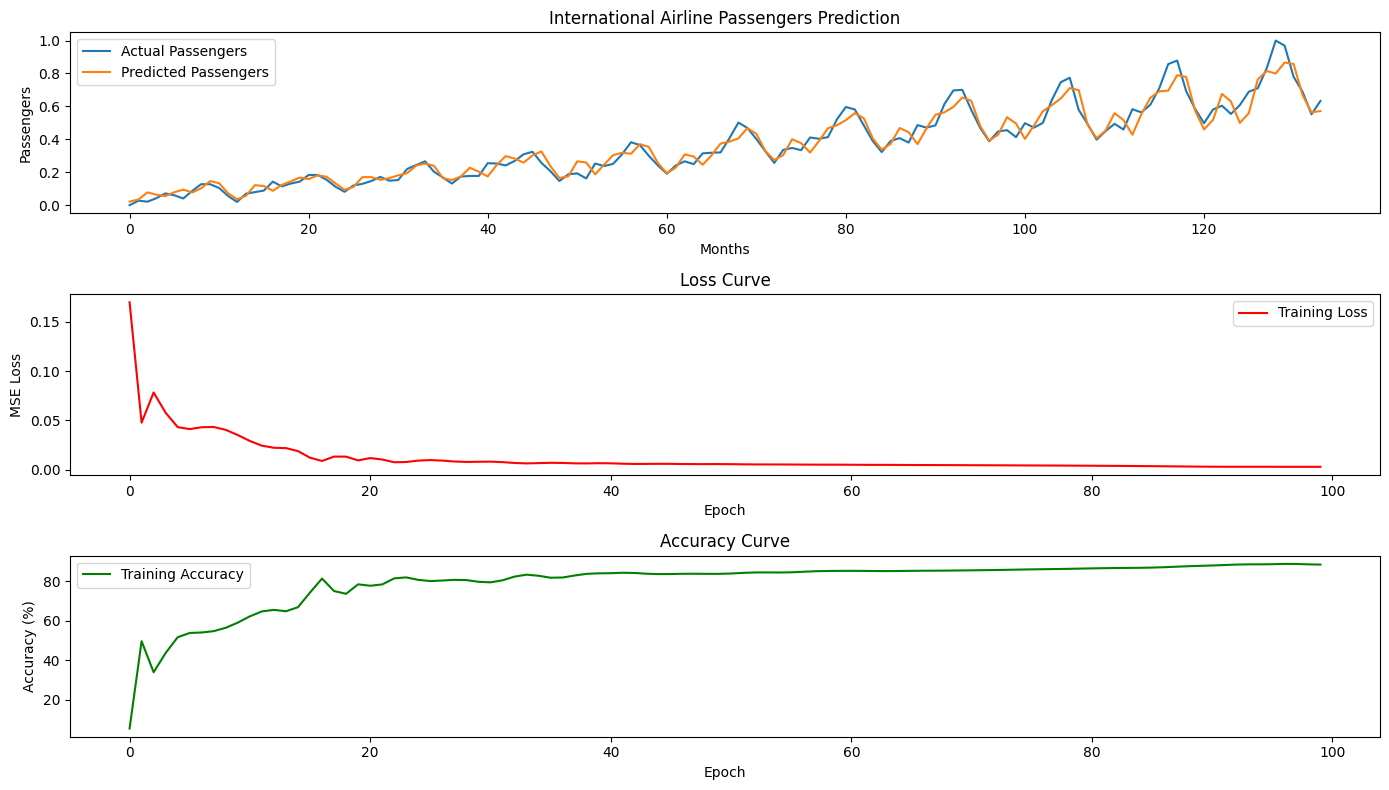

In [17]:
#  Evaluation
model.eval()
predicted = model(X).detach().numpy()
actual = y.detach().numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)

final_loss = np.mean((predicted.flatten() - actual.flatten())**2)
final_mae = np.mean(np.abs(predicted.flatten() - actual.flatten()))
final_mean_actual = np.mean(actual.flatten())
final_accuracy = 1 - (final_mae / final_mean_actual)

print(f"\nFinal MSE Loss: {final_loss:.4f}")
print(f"Final Custom Accuracy: {final_accuracy*100:.2f}%")


plt.figure(figsize=(14,8))


plt.subplot(3,1,1)
plt.plot(actual, label='Actual Passengers')
plt.plot(predicted, label='Predicted Passengers')
plt.title('International Airline Passengers Prediction')
plt.xlabel('Months')
plt.ylabel('Passengers')
plt.legend()

#  Loss Curve
plt.subplot(3,1,2)
plt.plot(losses, label='Training Loss', color='red')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Accuracy Curve
plt.subplot(3,1,3)
plt.plot(accuracies, label='Training Accuracy', color='green')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Description of code:-

a. Load and preprocess dataset:-   The dataset used for training the model is the Airline Passengers dataset.
The passenger numbers are normalized between 0 and 1 using MinMaxScaler from scikit-learn.
b.model architecture:-  train a Recurrent Neural Network using PyTorch Library to predict the next value in the dataset.This code defines a simple RNN model for handling sequential data. It first processes the input through an RNN layer, which captures patterns across the sequence over time. After going through the sequence, it takes the output from the final time step, assuming it carries the most important information. This output is then passed through a fully connected layer to generate the final prediction.

->hidden layer with 32 units and a single recurrent layer.

loss function: Mean Squared Error (MSE)

Optimizer: Adam optimizer

learning rate: 0.01.

Number of epochs: 100.

Sequences for RNN Input:

A helper function create_dataset prepares sequences of length seq_length (set to 10).

For each sequence, the model learns to predict the next passenger count.

create the RNN Model:

This consists of :

An RNN layer (nn.RNN) with specified input_size, hidden_size, and num_layers.

A fully connected (Linear) layer to output the final prediction.

In the forward pass:

The sequence output from the RNN is taken.

Only the last time step’s output is passed through the linear layer to predict the next value.

Train the Model:
Training runs for 100 epochs.
n each epoch:
Forward pass through the model.
Compute loss and backpropagate gradients.
Update model parameters.
Loss and a custom Accuracy (based on Mean Absolute Error) are calculated and stored for each epoch.
Every 10 epochs, the current loss and accuracy are printed.

Evaluation:
After training, the model is evaluated.
Final Mean Squared Error (MSE) and custom accuracy are calculated between the predicted and actual passenger counts.
Predictions and actual values are de-normalized (inverse of MinMax scaling) before evaluation.
Plots for "Predictions vs Actual Values", "Loss Curve" and "Accuracy Curve" are displayed.

Output:-

Final MSE Loss: 0.0031

Final Custom Accuracy: 88.39%



My Comments:-

In this case using LSTM gives even lower accuracy this is because this dataset being smaller in size does not require storing information and as such it perform well even on plain RNN.

Here plain RNN is used which works well for only small datasets, in case of lager ones the RNN does not perform well because of vanishing gradient problem. In such cases models like "Long Short-Term Memory (LSTM)" should be preferred.

Performance can be improved using LSTM / GRU.